### Metrics calculation and some plots
Use this notebook to calculate the BWT and FWT scores for the images the network. This works for the registration predictions as well as U-Net predictions. Just set the paths to the networks predictions correctly and the notebook will do the rest.

#### Set paths

In [1]:
unet_seq = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/UNet_Seq'
unet_si = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/UNet_SI'
unet_fdr = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/UNet_FDR'
unet_der = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/UNet_DER'
unet_agem = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/UNet_AGem'

#### Import necessary libraries

In [2]:
from math import pi
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
import SimpleITK as sitk
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os, copy, monai, torch
from tqdm.notebook import trange, tqdm

#### Helpful functions and other stuffs

In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

### UNet results

In [4]:
models = [x for x in os.listdir(unet_seq) if 'unet' in x.lower()]

models.sort()
dices_s = dict()
for model in models:
    dices_s[model.replace('_None', '').replace('UNet_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(unet_seq, model)) if 'inference' in x]

    for pred in preds_:
        preds = os.path.join(unet_seq, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_s[model.replace('_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_s[model.replace('_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_s[model.replace('_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_s[model.replace('_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_s[model.replace('_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_s[model.replace('_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Cardiac/Experiments/UNet_Seq/UNet_Heart88_None/inference..
Dice for model UNet_Heart88_None:
Task88_mHeartB: Mean dice +/- std: 100.0 (0.0)
Task89_mHeartA: Mean dice +/- std: 100.0 (0.0)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Cardiac/Experiments/UNet_Seq/UNet_Heart89_None/inference..
Dice for model UNet_Heart89_None:
Task88_mHeartB: Mean dice +/- std: 100.0 (0.0)
Task89_mHeartA: Mean dice +/- std: 100.0 (0.0)



In [35]:
# SI
models = [x for x in os.listdir(unet_si)  if 'unet' in x.lower()]

models.sort()
dices_si = dict()
for model in models:
    dices_si[model.replace('_si_None', '').replace('UNet_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(unet_si, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(unet_si, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_si[model.replace('_si_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_si[model.replace('_si_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_si[model.replace('_si_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_si[model.replace('_si_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_si[model.replace('_si_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_si[model.replace('_si_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_SI/UNet_Hyp97_si_None/inference..
Dice for model UNet_Hyp97_si_None:
Task97_DecathHip: Mean dice +/- std: 94.91 (2.86)
Task98_Dryad: Mean dice +/- std: 58.14 (18.69)
Task99_HarP: Mean dice +/- std: 43.88 (26.68)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_SI/UNet_Hyp98_si_None/inference..
Dice for model UNet_Hyp98_si_None:
Task97_DecathHip: Mean dice +/- std: 95.16 (3.11)
Task98_Dryad: Mean dice +/- std: 50.51 (12.5)
Task99_HarP: Mean dice +/- std: 31.48 (18.38)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_SI/UNet_Hyp99_98_97_si_None/inference..
Dice for model UNet_Hyp99_98_97_si_None:
Task97_DecathHip: Mean dice +/- std: 96.0 (3.65)
Task98_Dryad: Mean dice +/- std: 76.31 (3.15)
Task99_HarP: Mean dice +/- std: 62.44 (13.2)

Looking in /media/aranem_locale/AR_subs_exps/WACV_

In [36]:
# DER
models = [x for x in os.listdir(unet_der)  if 'unet' in x.lower()]

models.sort()
dices_der = dict()
for model in models:
    dices_der[model.replace('_der_None', '').replace('UNet_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(unet_der, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(unet_der, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_der[model.replace('_der_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_der[model.replace('_der_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_der[model.replace('_der_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_der[model.replace('_der_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_der[model.replace('_der_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_der[model.replace('_der_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_DER/UNet_Hyp97_der_None/inference..
Dice for model UNet_Hyp97_der_None:
Task97_DecathHip: Mean dice +/- std: 94.91 (2.86)
Task98_Dryad: Mean dice +/- std: 58.14 (18.69)
Task99_HarP: Mean dice +/- std: 43.88 (26.68)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_DER/UNet_Hyp98_der_None/inference..
Dice for model UNet_Hyp98_der_None:
Task97_DecathHip: Mean dice +/- std: 95.16 (3.11)
Task98_Dryad: Mean dice +/- std: 50.51 (12.5)
Task99_HarP: Mean dice +/- std: 31.48 (18.38)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_DER/UNet_Hyp99_98_97_der_None/inference..
Dice for model UNet_Hyp99_98_97_der_None:
Task97_DecathHip: Mean dice +/- std: 96.3 (3.65)
Task98_Dryad: Mean dice +/- std: 82.95 (2.37)
Task99_HarP: Mean dice +/- std: 71.48 (14.95)

Looking in /media/aranem_locale/AR_subs_

In [37]:
# FDR
models = [x for x in os.listdir(unet_fdr)  if 'unet' in x.lower()]

models.sort()
dices_fdr = dict()
for model in models:
    dices_fdr[model.replace('_fdr_None', '').replace('UNet_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(unet_fdr, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(unet_fdr, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_fdr[model.replace('_fdr_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_fdr[model.replace('_fdr_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_fdr[model.replace('_fdr_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_fdr[model.replace('_fdr_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_fdr[model.replace('_fdr_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_fdr[model.replace('_fdr_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_FDR/UNet_Hyp97_fdr_None/inference..
Dice for model UNet_Hyp97_fdr_None:
Task97_DecathHip: Mean dice +/- std: 94.91 (2.86)
Task98_Dryad: Mean dice +/- std: 58.14 (18.69)
Task99_HarP: Mean dice +/- std: 43.88 (26.68)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_FDR/UNet_Hyp98_fdr_None/inference..
Dice for model UNet_Hyp98_fdr_None:
Task97_DecathHip: Mean dice +/- std: 95.16 (3.11)
Task98_Dryad: Mean dice +/- std: 50.51 (12.5)
Task99_HarP: Mean dice +/- std: 31.48 (18.38)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_FDR/UNet_Hyp99_98_97_fdr_None/inference..
Dice for model UNet_Hyp99_98_97_fdr_None:
Task97_DecathHip: Mean dice +/- std: 96.32 (3.67)
Task98_Dryad: Mean dice +/- std: 79.97 (3.82)
Task99_HarP: Mean dice +/- std: 70.44 (11.54)

Looking in /media/aranem_locale/AR_subs

In [38]:
# AGem
models = [x for x in os.listdir(unet_agem)  if 'unet' in x.lower()]

models.sort()
dices_agem = dict()
for model in models:
    dices_agem[model.replace('_agem_None', '').replace('UNet_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(unet_agem, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(unet_agem, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_agem[model.replace('_agem_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_agem[model.replace('_agem_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_agem[model.replace('_agem_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_agem[model.replace('_agem_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_agem[model.replace('_agem_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_agem[model.replace('_agem_None', '').replace('UNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_AGem/UNet_Hyp97_agem_None/inference..
Dice for model UNet_Hyp97_agem_None:
Task97_DecathHip: Mean dice +/- std: 94.91 (2.86)
Task98_Dryad: Mean dice +/- std: 58.14 (18.69)
Task99_HarP: Mean dice +/- std: 43.88 (26.68)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_AGem/UNet_Hyp98_agem_None/inference..
Dice for model UNet_Hyp98_agem_None:
Task97_DecathHip: Mean dice +/- std: 95.16 (3.11)
Task98_Dryad: Mean dice +/- std: 50.51 (12.5)
Task99_HarP: Mean dice +/- std: 31.48 (18.38)

Looking in /media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_trained_models_Hip/Experiments/UNet_AGem/UNet_Hyp99_98_97_agem_None/inference..
Dice for model UNet_Hyp99_98_97_agem_None:
Task97_DecathHip: Mean dice +/- std: 95.83 (3.7)
Task98_Dryad: Mean dice +/- std: 78.17 (3.22)
Task99_HarP: Mean dice +/- std: 69.82 (13.78)

Looking in /media/aranem_locale

In [39]:
data = {'UNet': dices_s, 'SI': dices_si, 'DER': dices_der, 'FDR': dices_fdr, 'AGem': dices_agem
       }

#### Forgetting, Positive Backward Transfer, Remembering and Forward Transfer

In [40]:
tasks = ['99', '98', '97']
methods = ['UNet', 'SI', 'DER', 'FDR', 'AGem']
B_T, F_T, F_NEG, F_POS, B_TP, FOR, REM, Dice, Dice_F, Dice_L, STD = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
Dice_2 = dict()

all_t_j = '_'.join(tasks)
for m in methods:
    B_T[m], F_T[m], F_NEG[m], F_POS[m], B_TP[m], FOR[m], REM[m], Dice[m], Dice_F[m], Dice_L[m], STD[m] = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    Dice_2[m] = dict()
    t_list = list()
    for t in tasks:
        t_list.append(t)
        Dice_t_all = (data[m][all_t_j][t]['mean_dice_moved'],
                        data[m][all_t_j][t]['mean_std_moved'])
        
        Dice_t = (data[m]['_'.join(t_list)][t]['mean_dice_moved'],
                    data[m]['_'.join(t_list)][t]['mean_std_moved'])
        
        if len(t_list) > 1:
            Dice_t_prev = (data[m]['_'.join(t_list[:-1])][t]['mean_dice_moved'],
                            data[m]['_'.join(t_list[:-1])][t]['mean_std_moved'])
            F_T[m][t] = Dice_t_prev[0] - data[m][t][t]['mean_dice_moved']
            F_NEG[m][t] = abs(min(F_T[m][t], 0))
            F_POS[m][t] = 1 - abs(min(F_T[m][t], 0))
        
        if '_'.join(t_list) == all_t_j: # Only add this once
            Dice_F[m][t] = data[m][all_t_j][tasks[0]]['mean_dice_moved']
            Dice_2[m][t] = data[m][all_t_j][tasks[1]]['mean_dice_moved']
            Dice_L[m][t] = data[m][all_t_j][tasks[2]]['mean_dice_moved']
        
        Dice[m][t] = data[m][all_t_j][t]['mean_dice_moved']

        if '_'.join(t_list) != all_t_j:
            B_T[m][t] = Dice_t_all[0] - Dice_t[0]
            B_TP[m][t] = max(B_T[m][t], 0)
            FOR[m][t] = abs(min(B_T[m][t], 0))
            REM[m][t] = 1 - abs(min(B_T[m][t], 0))

In [52]:
print('BWT, FWT [%]')
for m in methods:
    print(m)
    print(np.mean(np.asarray(list(B_T[m].values()))*100), '+\-', np.std(np.asarray(list(B_T[m].values()))*100))
    # print(np.mean(np.asarray(list(REM[m].values()))*100), '+\-', np.std(np.asarray(list(REM[m].values()))*100))
    print(np.mean(np.asarray(list(F_T[m].values()))*100), '+\-', np.std(np.asarray(list(F_T[m].values()))*100))
    # print(np.mean(np.asarray(list(Dice[m].values()))*100), '+\-', np.std(np.asarray(list(Dice[m].values()))*100))

BWT, FWT [%]
UNet
-14.407259427286967 +\- 2.58693059561429
-9.233860213515488 +\- 44.782358844039166
SI
-19.09758623275492 +\- 4.524539071652627
-18.555913671426914 +\- 52.44748662369742
DER
-11.671302931176285 +\- 3.6480879949198792
-4.345628082877592 +\- 39.21757465613504
FDR
-13.707015514373783 +\- 2.882056832313534
-9.949806801657985 +\- 45.508654586654025
AGem
-14.879213830939047 +\- 2.055343648901693
-5.648240380553311 +\- 40.773042969969815


In [42]:
print('Mean Dice [%]')
for m in methods:
    print(m)
    print(np.mean(list(Dice[m].values()))*100)
    print(np.std(list(Dice[m].values()))*100)

Mean Dice [%]
UNet
81.74564610547603
11.053000152900514
SI
78.25240603192637
13.768603265528897
DER
83.58040035379464
10.137736919889555
FDR
82.24963462915969
10.684596205507567
AGem
81.27403896128632
10.843201734364632


In [43]:
print('Mean Forgetting [%]')
for m in methods:
    print(m)
    print(np.mean(list(FOR[m].values()))*100)

Mean Forgetting [%]
UNet
14.407259427286967
SI
19.09758623275492
DER
11.671302931176285
FDR
13.707015514373783
AGem
14.879213830939047


#### Spider Plots

In [44]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'Dice Mean': [np.mean(list(Dice[m].values()))*100 for m in methods],
'100 + BWT': [100 + np.mean(list(B_T[m].values()))*100 for m in methods],
'Dice Last': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
'Dice First': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'100 + FWT': [100 + np.mean(list(F_T[m].values()))*100 for m in methods]
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # ax.xaxis.set_tick_params(pad=35)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    
    for i, tick in enumerate(ax.get_xaxis().get_major_ticks()):
        if i == 1 or i == 4:
            tick.set_pad(35)
        else:
            tick.set_pad(15)

    # Draw ylabels
    # ax.set_rlabel_position(0)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=9)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

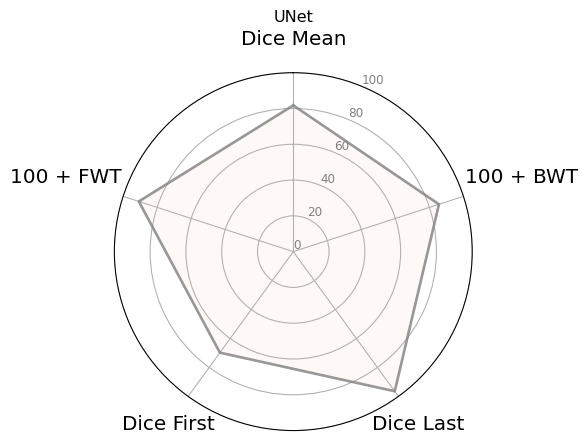

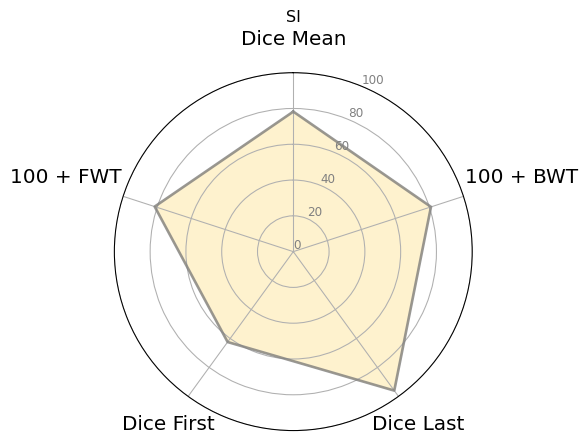

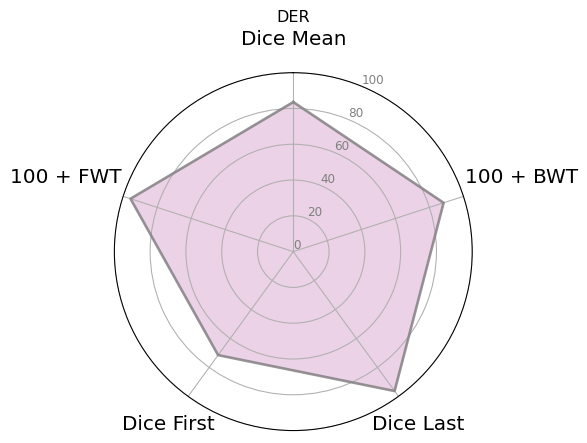

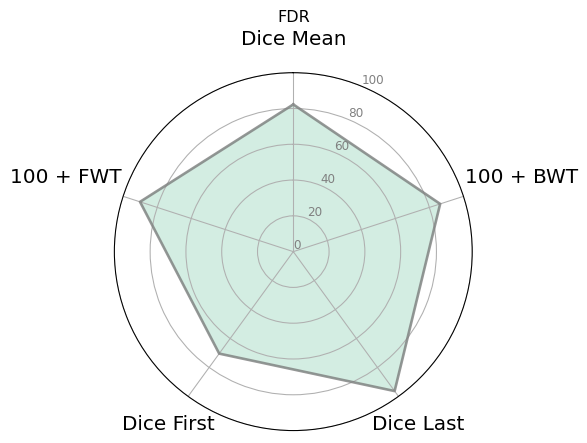

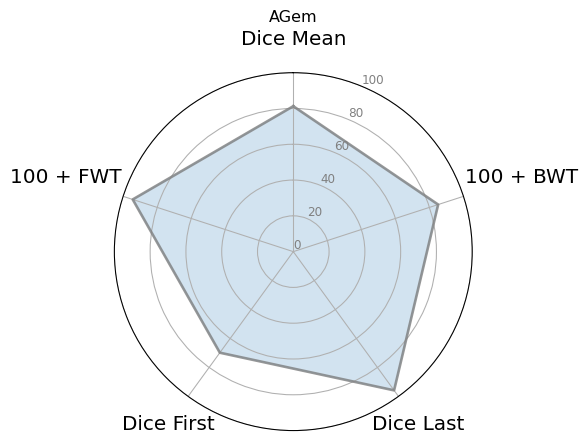

In [45]:
# ------- PART 2: Apply the function to all individuals
colors = {'UNet': '#fae5d6', 'SI':'#fec10b', 'DER':'#9e1e83', 'FDR': '#26a671', 'AGem': '#1f77b4'}

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_evaluation/plots/hip_spiders_UNet_{title}.pdf', bbox_inches='tight')

In [46]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'$\mathcal{T}_{1}$': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'$\mathcal{T}_{2}$': [np.mean(list(Dice_2[m].values()))*100 for m in methods],
'$\mathcal{T}_{3}$': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.xaxis.set_tick_params(pad=15)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    # plt.xticks(angles[:-1], categories, color='black', size=15)
    plt.xticks(angles[:-1], categories, color='black', size=31)
    
    # Draw ylabels
    # ax.set_rlabel_position(0)
    # plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=11)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=15)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

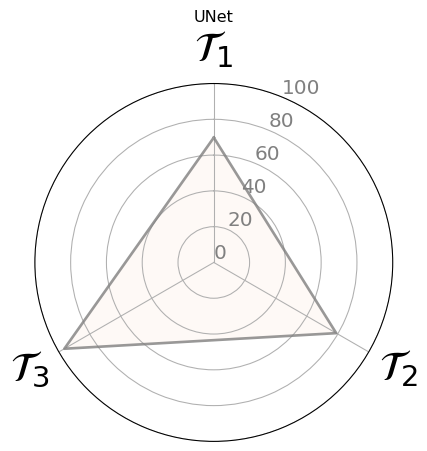

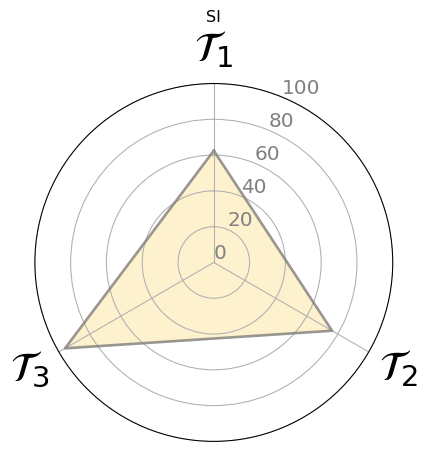

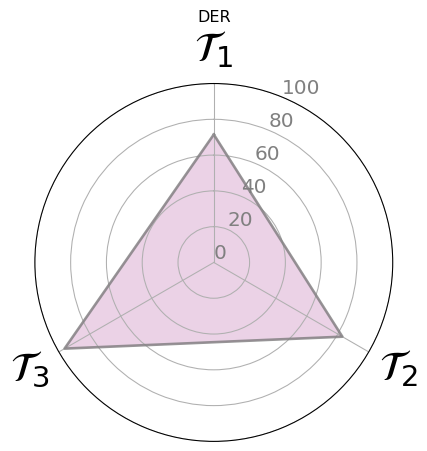

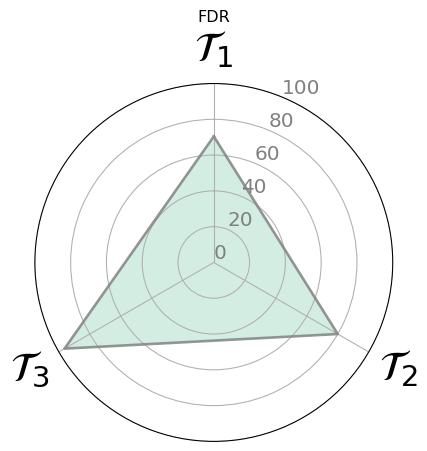

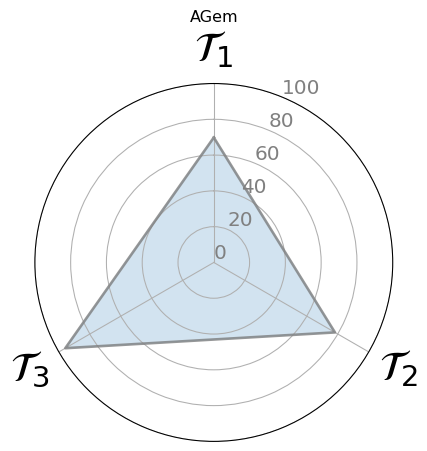

In [47]:
# ------- PART 2: Apply the function to all individuals
colors = {'UNet': '#fae5d6', 'SI':'#fec10b', 'DER':'#9e1e83', 'FDR': '#26a671', 'AGem': '#1f77b4'}

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/media/aranem_locale/AR_subs_exps/WACV_2025/WACV_2025_evaluation/plots/hip_spiders_UNet_{title}_dices.pdf', bbox_inches='tight')